In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
import time
from tqdm import tqdm

In [2]:
def solve_hetdp_cor(eps, k, beta, num_solver):
	n = len(eps)
	ones = np.ones(n)

	w = cp.Variable(n)
	objective2 = cp.Minimize(cp.power(cp.norm(w/eps,'inf'),2)*((np.log(k/beta))**2) + cp.power(cp.norm(w - (ones/n),1),2))
	constraints2 = [0 <= w, w@ones == 1]
	prob2 = cp.Problem(objective2, constraints2)
	result2 = prob2.solve(solver = num_solver)

	return w.value, np.sqrt(result2)



def solve_hetdp_uncor(eps, k, beta, num_solver):
	n = len(eps)
	ones = np.ones(n)

	w = cp.Variable(n)
	objective1 = cp.Minimize(cp.power(cp.norm(w/eps,'inf'),2)*((np.log(k/beta))**2) + cp.power(cp.norm(w - (ones/n),1),2))
	constraints1 = [0 <= w, w@ones == 1]
	prob1 = cp.Problem(objective1, constraints1)
	result1 = prob1.solve(solver = num_solver)

	w2 = cp.Variable(n)
	objective2 = cp.Minimize(cp.power(cp.norm(w2/eps,'inf'),2)*((np.log(k/beta))**2) + cp.power(cp.norm(w2,2),2)*np.log(k/beta))
	constraints2 = [0 <= w2, w2@ones == 1]
	prob2 = cp.Problem(objective2, constraints2)
	result2 = prob2.solve(solver = num_solver)

	if result1 < result2:
		return w.value, np.sqrt(result1)
	else:
		return w2.value, np.sqrt(result2)

In [3]:
def solve_ldp_cor(eps, k, beta):
	n = len(eps)
	ones = np.ones(n)
	coefs = n+((np.log(k/beta))/(np.tanh(eps/4)*eps))

	w = 1/coefs
	w = w/np.sum(w)
	return w, 1

def solve_ldp_uncor(eps, k, beta):
	n = len(eps)
	ones = np.ones(n)
	coefs = 1+(1/(np.tanh(eps/4)*eps))

	w = 1/coefs
	w = w/np.sum(w)
	return w, 1

def kRAPPOR_cor(eps, Dmatrix, trials):
	#Dmatrix is k x n
	n = len(eps)
	k = Dmatrix.shape[0]

	probs = np.exp(eps/2)/(1+np.exp(eps/2))
	bias = 1/(1+np.exp(eps/2))

	response_noise = np.random.binomial(1, probs, (trials, k, n))
	Data = Dmatrix.copy()
	ldp_data = Data*response_noise + (1-Data)*(1-response_noise)
	ldp_data_unbiased = (ldp_data - bias)/np.tanh(eps/4)
	return ldp_data_unbiased

def kRAPPOR_uncor(eps, Dmatrix, trials):
	#Dmatrix is k x n
	n = len(eps)

	probs = np.exp(eps/2)/(1+np.exp(eps/2))
	bias = 1/(1+np.exp(eps/2))

	response_noise = np.random.binomial(1, probs, (k, n))
	ldp_data = Dmatrix*response_noise + (1-Dmatrix)*(1-response_noise)
	ldp_data_unbiased = (ldp_data - bias)/np.tanh(eps/4)
	return ldp_data_unbiased

In [4]:
def get_error(est,counts):
	return min(np.max(np.abs(est - counts)),1)
def get_error_vector(est,counts):
	## est is trials x k
	## counts is k
	return np.minimum(np.max(np.abs(est-counts),axis=1),1)
	

In [5]:
def gen_dataset(n,k, lamb=1):

	p = np.power(lamb,np.arange(k))
	p = p/np.sum(p)

	D = np.random.choice(k, size = n, p = p)
	DMatrix = np.zeros((k,n))
	for i in range(n):
		DMatrix[D[i],i] = 1
	
	counts = np.sum(DMatrix,axis=1)
	return DMatrix, counts

## UC Salary, C, P

In [6]:
## Real Dataset
np.random.seed(1)
df =  pd.read_csv('UCData.csv')
x = np.array(df['TotalWages'])
print(len(x))
x = np.random.choice(x,50000,replace=False) #sub-sample dataset

counts, bins = np.histogram(x, bins = [0,1000,5000,15000,30000,60000,120000,240000,480000,960000,2000000,4000000,8000000])
Data = np.zeros((12,len(x)))
ct = 0 
for i in range(len(counts)):
	Data[i,ct:ct+counts[i]] = 1
	ct += counts[i]

np.random.seed(1)
eps = np.zeros(len(x))
ct = 0 
for i in range(len(counts)):
	eps[ct:ct+counts[i]] = np.exp(-abs(i-5.5) + np.random.uniform(-3,3,counts[i]))
	ct += counts[i]

324043


In [7]:
### Correlated
np.random.seed(1)
beta = 0.05
n = len(x)
k = 12
trials = 5000

Dmatrix = Data
counts = np.sum(Dmatrix,axis=1)/n
print('Counts is ',counts)

### hpfc ###
begin = time.time()
w_hpfc, result = solve_hetdp_cor(eps, k, beta, cp.ECOS)
L_hpfc = 2*np.max(w_hpfc/eps)
N_hpfc = np.random.laplace(0,L_hpfc,(k,trials))
end = time.time()
print('Done HPF-C in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = 2*infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,(k,trials))
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### Prop ###
begin = time.time()
w_prop = eps
w_prop = w_prop/np.sum(w_prop)
L_prop = 2*np.max(w_prop/eps)
N_prop = np.random.laplace(0,L_prop,(k,trials))
end = time.time()
print('Done Prop in ',end-begin,' seconds')


### UNI ###
begin = time.time()
eps1 = np.min(eps)
w_uni = np.ones(n)/n
L_uni = 2*np.max(1/eps)/n
N_uni = np.random.laplace(0,L_uni,(k,trials))
end = time.time()
print('Done UNI in ',end-begin,' seconds')


### SM ###
begin = time.time()
t = np.max(eps)
sm_bern_matrix = np.random.binomial(1,(np.exp(eps)-1)/(np.exp(t)-1), (trials,n))
N_sm = np.random.laplace(0,2/(t*np.sum(sm_bern_matrix, axis=1)),size = (k,trials))
end = time.time()
print('Done SM in ',end-begin,' seconds')


### LDP ###
begin = time.time()
w_ldp, result = solve_ldp_cor(eps, k, beta)
ldp_data_matrix = kRAPPOR_cor(eps, Dmatrix, trials)
end = time.time()
print('Done LDP in ',end-begin,' seconds')

Counts is  [6.7060e-02 1.4894e-01 1.2924e-01 9.5000e-02 1.6980e-01 2.2798e-01
 1.2630e-01 2.9740e-02 5.3800e-03 5.4000e-04 0.0000e+00 2.0000e-05]


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done HPF-C in  8.24040699005127  seconds
Done HPF-A in  0.003773927688598633  seconds
Done Prop in  0.0029408931732177734  seconds
Done UNI in  0.0025908946990966797  seconds
Done SM in  9.922703742980957  seconds
Done LDP in  615.7520160675049  seconds


In [8]:
errors_hpfc = get_error_vector(Dmatrix@w_hpfc + N_hpfc.transpose(),counts)
errors_hpfa = get_error_vector(Dmatrix@w_hpfa + N_hpfa.transpose(),counts)
errors_prop = get_error_vector(Dmatrix@w_prop + N_prop.transpose(),counts)
errors_uni = get_error_vector(Dmatrix@w_uni + N_uni.transpose(),counts)
errors_ldp = get_error_vector(ldp_data_matrix@w_ldp,counts)
est_sm = get_error_vector((Dmatrix@sm_bern_matrix.transpose()/np.sum(sm_bern_matrix,axis=1) + N_sm).transpose(),counts)

In [59]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpfc), min(errors_uni) , min(errors_ldp), min(errors_prop))
max_range = max(max(errors_hpfa),max(errors_hpfc), max(errors_uni) , max(errors_ldp), max(errors_prop))
BINS = 10 ** np.linspace(np.log10(min_range), np.log10(max_range*2), 100)

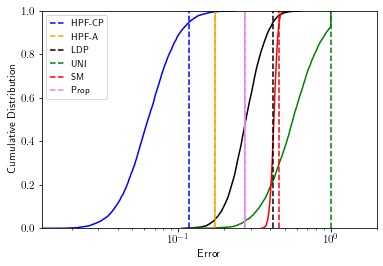

In [60]:
plt.xscale('log')

plt.plot(np.sort(errors_hpfc), np.linspace(0, 1, len(errors_hpfc), endpoint=False), alpha = 1,color='blue')
plt.plot(np.sort(errors_hpfa), np.linspace(0, 1, len(errors_hpfa), endpoint=False), alpha = 1,color='orange')
plt.plot(np.sort(errors_ldp), np.linspace(0, 1, len(errors_ldp), endpoint=False), alpha = 1,color='black')
plt.plot(np.sort(errors_uni), np.linspace(0, 1, len(errors_uni), endpoint=False), alpha = 1,color='green')
plt.plot(np.sort(est_sm), np.linspace(0, 1, len(est_sm), endpoint=False), alpha = 1,color='red')
plt.plot(np.sort(errors_prop), np.linspace(0, 1, len(errors_prop), endpoint=False), alpha = 1,color='violet')

plt.ylim(0,1)
plt.xlim(min_range, max_range*2)

plt.axvline(x = np.quantile(errors_hpfc,0.95), color = 'blue', linestyle = '--', label=r'HPF-CP',)
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPF-A')
plt.axvline(x = np.quantile(errors_ldp,0.95), color = 'black', linestyle = '--', label='LDP')
plt.axvline(x = np.quantile(errors_uni,0.95), color = 'green', linestyle = '--', label='UNI')
plt.axvline(x = np.quantile(est_sm,0.95), color = 'red', linestyle = '--', label='SM')
plt.axvline(x = np.quantile(errors_prop,0.95), color = 'violet', linestyle = '--', label='Prop')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')

plt.legend(loc='upper left')
plt.savefig("UC-CP.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [56]:
print(np.quantile(errors_hpfc,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_uni,0.95), np.quantile(errors_ldp,0.95), np.quantile(est_sm,0.95), np.quantile(errors_prop,0.95))
print(np.mean(np.square(errors_hpfc)), np.mean(np.square(errors_hpfa)), np.mean(np.square(errors_uni)), np.mean(np.square(errors_ldp)), np.mean(np.square(est_sm)), np.mean(np.square(errors_prop)))


0.11840227521082926 0.17428931186696694 1.0 0.4199777524639769 0.4592659815536066 0.2728653689603686
0.0053560635212549996 0.03026483894508084 0.3961585760412722 0.08741147791176891 0.17986458918891915 0.07439960150569744


In [55]:
## Saving performance:
errors_hpfc_UC = errors_hpfc
errors_hpfa_UC = errors_hpfa
errors_ldp_UC = errors_ldp
errors_uni_UC = errors_uni
est_sm_UC = est_sm
errors_prop_UC = errors_prop


## UC Salary, C, E

In [16]:
### Correlated
np.random.seed(1)
beta = 1
n = len(x)
k = 12
trials = 5000

Dmatrix = Data
counts = np.sum(Dmatrix,axis=1)/n
print('Counts is ',counts)

### hpfc ###
begin = time.time()
w_hpfc, result = solve_hetdp_cor(eps, k, beta, cp.ECOS)
L_hpfc = 2*np.max(w_hpfc/eps)
N_hpfc = np.random.laplace(0,L_hpfc,(k,trials))
end = time.time()
print('Done HPF-C in ',end-begin,' seconds')

errors_hpfce = get_error_vector(Dmatrix@w_hpfc + N_hpfc.transpose(),counts)

print(np.mean(np.square(errors_hpfce)))



Counts is  [6.7060e-02 1.4894e-01 1.2924e-01 9.5000e-02 1.6980e-01 2.2798e-01
 1.2630e-01 2.9740e-02 5.3800e-03 5.4000e-04 0.0000e+00 2.0000e-05]
Done HPF-C in  9.009101152420044  seconds
0.011740334529033301


## Correlated Synthetic Dataset, k = 5

In [17]:
## Synthetic Dataset
np.random.seed(1)
beta = 0.05
n = 10000
k = 5


Data = np.zeros((k,n))
_, counts = gen_dataset(n,k,0.8)
ct = 0 
print(counts)
for i in range(len(counts)):
	Data[i,ct:ct+int(counts[i])] = 1
	ct += int(counts[i])
eps = np.zeros(n)
ct = 0 
for i in range(len(counts)):
	eps[ct:ct+int(counts[i])] = np.exp(-2*i+np.random.uniform(0,3*i,int(counts[i])))
	ct += int(counts[i])


trials = 5000
Dmatrix = Data
counts = counts/n

print('Counts is ',counts)

### hpfc ###
begin = time.time()
w_hpfc, result = solve_hetdp_cor(eps, k, beta, cp.ECOS)
L_hpfc = 2*np.max(w_hpfc/eps)
N_hpfc = np.random.laplace(0,L_hpfc,(k,trials))
end = time.time()
print('Done HPF-C in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = 2*infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,(k,trials))
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### Prop ###
begin = time.time()
w_prop = eps
w_prop = w_prop/np.sum(w_prop)
L_prop = 2*np.max(w_prop/eps)
N_prop = np.random.laplace(0,L_prop,(k,trials))
end = time.time()
print('Done Prop in ',end-begin,' seconds')


### UNI ###
begin = time.time()
eps1 = np.min(eps)
w_uni = np.ones(n)/n
L_uni = 2*np.max(1/eps)/n
N_uni = np.random.laplace(0,L_uni,(k,trials))
end = time.time()
print('Done UNI in ',end-begin,' seconds')


### SM ###
begin = time.time()
t = np.max(eps)
sm_bern_matrix = np.random.binomial(1,(np.exp(eps)-1)/(np.exp(t)-1), (trials,n))
N_sm = np.random.laplace(0,2/(t*np.sum(sm_bern_matrix, axis=1)),size = (k,trials))
end = time.time()
print('Done SM in ',end-begin,' seconds')


### LDP ###
begin = time.time()
w_ldp, result = solve_ldp_cor(eps, k, beta)
ldp_data_matrix = kRAPPOR_cor(eps, Dmatrix, trials)
end = time.time()
print('Done LDP in ',end-begin,' seconds')

[3040. 2298. 1962. 1518. 1182.]
Counts is  [0.304  0.2298 0.1962 0.1518 0.1182]
Done HPF-C in  1.1550378799438477  seconds
Done HPF-A in  0.002743959426879883  seconds
Done Prop in  0.0034377574920654297  seconds
Done UNI in  0.00428318977355957  seconds
Done SM in  1.6035029888153076  seconds
Done LDP in  28.604459047317505  seconds


In [18]:
errors_hpfc = get_error_vector(Dmatrix@w_hpfc + N_hpfc.transpose(),counts)
errors_hpfa = get_error_vector(Dmatrix@w_hpfa + N_hpfa.transpose(),counts)
errors_prop = get_error_vector(Dmatrix@w_prop + N_prop.transpose(),counts)
errors_uni = get_error_vector(Dmatrix@w_uni + N_uni.transpose(),counts)
errors_ldp = get_error_vector(ldp_data_matrix@w_ldp,counts)
est_sm = get_error_vector((Dmatrix@sm_bern_matrix.transpose()/np.sum(sm_bern_matrix,axis=1) + N_sm).transpose(),counts)

In [19]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpfc), min(errors_uni) , min(errors_ldp), min(errors_prop))
max_range = max(max(errors_hpfa),max(errors_hpfc), max(errors_uni) , max(errors_ldp), max(errors_prop))

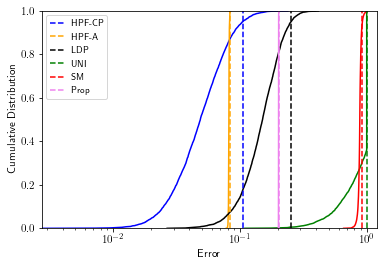

In [22]:
plt.xscale('log')

plt.plot(np.sort(errors_hpfc), np.linspace(0, 1, len(errors_hpfc), endpoint=False), alpha = 1,color='blue')
plt.plot(np.sort(errors_hpfa), np.linspace(0, 1, len(errors_hpfa), endpoint=False), alpha = 1,color='orange')
plt.plot(np.sort(errors_ldp), np.linspace(0, 1, len(errors_ldp), endpoint=False), alpha = 1,color='black')
plt.plot(np.sort(errors_uni), np.linspace(0, 1, len(errors_uni), endpoint=False), alpha = 1,color='green')
plt.plot(np.sort(est_sm), np.linspace(0, 1, len(est_sm), endpoint=False), alpha = 1,color='red')
plt.plot(np.sort(errors_prop), np.linspace(0, 1, len(errors_prop), endpoint=False), alpha = 1,color='violet')


plt.ylim(0,1)
plt.xlim(min_range, max_range*1.2)

plt.axvline(x = np.quantile(errors_hpfc,0.95), color = 'blue', linestyle = '--', label=r'HPF-CP',)
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPF-A')
plt.axvline(x = np.quantile(errors_ldp,0.95), color = 'black', linestyle = '--', label='LDP')
plt.axvline(x = np.quantile(errors_uni,0.95), color = 'green', linestyle = '--', label='UNI')
plt.axvline(x = np.quantile(est_sm,0.95), color = 'red', linestyle = '--', label='SM')
plt.axvline(x = np.quantile(errors_prop,0.95), color = 'violet', linestyle = '--', label='Prop')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')

plt.legend(loc='upper left')
plt.savefig("CorrSyn1.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [23]:
print(np.quantile(errors_hpfc,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_uni,0.95), np.quantile(errors_ldp,0.95), np.quantile(est_sm,0.95), np.quantile(errors_prop,0.95))

0.10509338854214294 0.08281306736934593 1.0 0.2531385075098613 0.9243870968439448 0.20202101595850294


In [24]:
### Saving results:
errors_hpfc_syn1 = errors_hpfc
errors_hpfa_syn1 = errors_hpfa
errors_ldp_syn1 = errors_ldp
errors_uni_syn1 = errors_uni
est_sm_syn1 = est_sm
errors_prop_syn1 = errors_prop


## Corr Syn E

In [25]:
## Synthetic Dataset
np.random.seed(1)
beta = 1
n = 10000
k = 5


Data = np.zeros((k,n))
_, counts = gen_dataset(n,k,0.8)
ct = 0 
print(counts)
for i in range(len(counts)):
	Data[i,ct:ct+int(counts[i])] = 1
	ct += int(counts[i])
eps = np.zeros(n)
ct = 0 
for i in range(len(counts)):
	eps[ct:ct+int(counts[i])] = np.exp(-2*i+np.random.uniform(0,3*i,int(counts[i])))
	ct += int(counts[i])


trials = 5000
Dmatrix = Data
counts = counts/n

print('Counts is ',counts)

### hpfc ###
begin = time.time()
w_hpfc, result = solve_hetdp_cor(eps, k, beta, cp.ECOS)
L_hpfc = 2*np.max(w_hpfc/eps)
N_hpfc = np.random.laplace(0,L_hpfc,(k,trials))
end = time.time()
print('Done HPF-C in ',end-begin,' seconds')

errors_hpfce = get_error_vector(Dmatrix@w_hpfc + N_hpfc.transpose(),counts)
print(np.mean(np.square(errors_hpfce)), np.mean(np.square(errors_hpfa)), np.mean(np.square(errors_uni)), np.mean(np.square(errors_ldp)), np.mean(np.square(est_sm)), np.mean(np.square(errors_prop)))

[3040. 2298. 1962. 1518. 1182.]
Counts is  [0.304  0.2298 0.1962 0.1518 0.1182]
Done HPF-C in  1.0897362232208252  seconds
0.012220387232543161 0.006704256976892647 0.8338290013753503 0.027319142573688355 0.7785149310255952 0.040694668362651044


## Correlated Synthetic k = 20

In [26]:
## Synthetic Dataset
np.random.seed(1)
beta = 0.05
n = 10000
k = 20


Data = np.zeros((k,n))
_, counts = gen_dataset(n,k,0.8)
ct = 0 
print(counts)
for i in range(len(counts)):
	Data[i,ct:ct+int(counts[i])] = 1
	ct += int(counts[i])
eps = np.zeros(n)
ct = 0 
for i in range(len(counts)):
	eps[ct:ct+int(counts[i])] = np.exp(np.random.uniform(-0.3*i,0.3*i,int(counts[i])))
	ct += int(counts[i])


trials = 5000
Dmatrix = Data
counts = counts/n

print('Counts is ',counts)

### hpfc ###
begin = time.time()
w_hpfc, result = solve_hetdp_cor(eps, k, beta, cp.ECOS)
L_hpfc = 2*np.max(w_hpfc/eps)
N_hpfc = np.random.laplace(0,L_hpfc,(k,trials))
end = time.time()
print('Done HPF-CP in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = 2*infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,(k,trials))
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### Prop ###
begin = time.time()
w_prop = eps
w_prop = w_prop/np.sum(w_prop)
L_prop = 2*np.max(w_prop/eps)
N_prop = np.random.laplace(0,L_prop,(k,trials))
end = time.time()
print('Done Prop in ',end-begin,' seconds')


### UNI ###
begin = time.time()
eps1 = np.min(eps)
w_uni = np.ones(n)/n
L_uni = 2*np.max(1/eps)/n
N_uni = np.random.laplace(0,L_uni,(k,trials))
end = time.time()
print('Done UNI in ',end-begin,' seconds')


### SM ###
begin = time.time()
t = np.max(eps)
sm_bern_matrix = np.random.binomial(1,(np.exp(eps)-1)/(np.exp(t)-1), (trials,n))
N_sm = np.random.laplace(0,2/(t*np.sum(sm_bern_matrix, axis=1)),size = (k,trials))
end = time.time()
print('Done SM in ',end-begin,' seconds')


### LDP ###
begin = time.time()
w_ldp, result = solve_ldp_cor(eps, k, beta)
ldp_data_matrix = kRAPPOR_cor(eps, Dmatrix, trials)
end = time.time()
print('Done LDP in ',end-begin,' seconds')


begin = time.time()
w_hpfce, result = solve_hetdp_cor(eps, k, 1, cp.ECOS)
L_hpfce = 2*np.max(w_hpfce/eps)
N_hpfce = np.random.laplace(0,L_hpfce,(k,trials))
end = time.time()
print('Done HPF-CE in ',end-begin,' seconds')


[2029. 1632. 1253. 1117.  794.  683.  527.  410.  344.  276.  217.  179.
  121.   88.   88.   82.   56.   49.   27.   28.]
Counts is  [0.2029 0.1632 0.1253 0.1117 0.0794 0.0683 0.0527 0.041  0.0344 0.0276
 0.0217 0.0179 0.0121 0.0088 0.0088 0.0082 0.0056 0.0049 0.0027 0.0028]


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done HPF-CP in  1.0915436744689941  seconds
Done HPF-A in  0.004186868667602539  seconds
Done Prop in  0.003717184066772461  seconds
Done UNI in  0.004034996032714844  seconds
Done SM in  1.4008870124816895  seconds
Done LDP in  113.45682311058044  seconds
Done HPF-CE in  1.2125048637390137  seconds


In [27]:
errors_hpfc = get_error_vector(Dmatrix@w_hpfc + N_hpfc.transpose(),counts)
errors_hpfa = get_error_vector(Dmatrix@w_hpfa + N_hpfa.transpose(),counts)
errors_prop = get_error_vector(Dmatrix@w_prop + N_prop.transpose(),counts)
errors_uni = get_error_vector(Dmatrix@w_uni + N_uni.transpose(),counts)
errors_ldp = get_error_vector(ldp_data_matrix@w_ldp,counts)
errors_sm = get_error_vector((Dmatrix@sm_bern_matrix.transpose()/np.sum(sm_bern_matrix,axis=1) + N_sm).transpose(),counts)
errors_hpfce = get_error_vector(Dmatrix@w_hpfce + N_hpfce.transpose(),counts)

In [28]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpfc), min(errors_uni) , min(errors_ldp), min(errors_prop))
max_range = max(max(errors_hpfa),max(errors_hpfc), max(errors_uni) , max(errors_ldp), max(errors_prop))

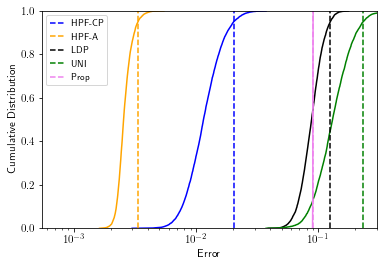

In [43]:
plt.xscale('log')

plt.plot(np.sort(errors_hpfc), np.linspace(0, 1, len(errors_hpfc), endpoint=False), alpha = 1,color='blue')
plt.plot(np.sort(errors_hpfa), np.linspace(0, 1, len(errors_hpfa), endpoint=False), alpha = 1,color='orange')
plt.plot(np.sort(errors_ldp), np.linspace(0, 1, len(errors_ldp), endpoint=False), alpha = 1,color='black')
plt.plot(np.sort(errors_uni), np.linspace(0, 1, len(errors_uni), endpoint=False), alpha = 1,color='green')
plt.plot(np.sort(est_sm), np.linspace(0, 1, len(est_sm), endpoint=False), alpha = 1,color='red')
plt.plot(np.sort(errors_prop), np.linspace(0, 1, len(errors_prop), endpoint=False), alpha = 1,color='violet')


plt.ylim(0,1)
plt.xlim(min_range, 0.3)

plt.axvline(x = np.quantile(errors_hpfc,0.95), color = 'blue', linestyle = '--', label='HPF-CP',)
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPF-A')
plt.axvline(x = np.quantile(errors_ldp,0.95), color = 'black', linestyle = '--', label='LDP')
plt.axvline(x = np.quantile(errors_uni,0.95), color = 'green', linestyle = '--', label='UNI')
#plt.axvline(x = np.quantile(errors_sm,0.95), color = 'red', linestyle = '--', label='SM')
plt.axvline(x = np.quantile(errors_prop,0.95), color = 'violet', linestyle = '--', label='Prop')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')

plt.legend(loc='upper left')
plt.savefig("CorrSyn2.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [42]:
print(np.quantile(errors_hpfc,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_prop,0.95), np.quantile(errors_uni,0.95), np.quantile(errors_sm,0.95), np.quantile(errors_ldp,0.95) )
print(np.mean(np.square(errors_hpfce)), np.mean(np.square(errors_hpfa)), np.mean(np.square(errors_uni)), np.mean(np.square(errors_ldp)), np.mean(np.square(est_sm)), np.mean(np.square(errors_prop)))

0.020236980582578393 0.003343892067475588 0.09035949685512419 0.23229171758629233 1.0 0.1248234805141269
0.0003095090066237647 7.009998132099727e-06 0.021878911016569674 0.00841545354386958 0.7785149310255952 0.008119535559311641


In [44]:

### Saving results:
errors_hpfc_syn2 = errors_hpfc
errors_hpfa_syn2 = errors_hpfa
errors_ldp_syn2 = errors_ldp
errors_uni_syn2 = errors_uni
errors_sm_syn2 = errors_sm
errors_prop_syn2 = errors_prop



## Uncorrelated Dataset : Cancer

In [6]:
## Real Cancer Dataset
#counts = np.array([933,3268,31521,7354,470,1472,3279,1095,3013,3590,976])
counts = np.array([4083,3372,2373,1772,1158,1066,983,909,790,730])
total = np.sum(counts)
print(total)
k = len(counts)
n = total
Data = np.zeros((k,n))
ct = 0 
for i in range(len(counts)):
	Data[i,ct:ct+counts[i]] = 1
	ct += counts[i]

np.random.seed(1)
eps = np.exp(np.random.uniform(-5,5,n))

17236


In [7]:
### Uncorrelated
np.random.seed(1)
beta = 0.05
trials = int(n*np.log(n))

Dmatrix = Data
counts = np.sum(Dmatrix,axis=1)/n
print('Counts is ',counts)

### hpfu ###
begin = time.time()
w_hpfu, result = solve_hetdp_uncor(eps, k, beta, cp.ECOS)
L_hpfu = 2*np.max(w_hpfu/eps)
N_hpfu = np.random.laplace(0,L_hpfu,(k,trials))
end = time.time()
print('Done HPF-U in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = 2*infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,(k,trials))
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### Prop ###
begin = time.time()
w_prop = eps
w_prop = w_prop/np.sum(w_prop)
L_prop = 2*np.max(w_prop/eps)
N_prop = np.random.laplace(0,L_prop,(k,trials))
end = time.time()
print('Done Prop in ',end-begin,' seconds')


### UNI ###
begin = time.time()
eps1 = np.min(eps)
w_uni = np.ones(n)/n
L_uni = 2*np.max(1/eps)/n
N_uni = np.random.laplace(0,L_uni,(k,trials))
end = time.time()
print('Done UNI in ',end-begin,' seconds')

### SM ###
begin = time.time()
t = np.max(eps)
sm_bern_matrix = np.random.binomial(1,(np.exp(eps)-1)/(np.exp(t)-1), (trials,n))
N_sm = np.random.laplace(0,2/(t*np.sum(sm_bern_matrix, axis=1)),size = (k,trials))
end = time.time()
print('Done SM in ',end-begin,' seconds')


### LDP ###
begin = time.time()
w_ldp, result = solve_ldp_uncor(eps, k, beta)
end = time.time()
print('Done LDP in ',end-begin,' seconds')

### hpfue ###
begin = time.time()
w_hpfue, result = solve_hetdp_uncor(eps, k, 1, cp.ECOS)
L_hpfue = 2*np.max(w_hpfue/eps)
N_hpfue = np.random.laplace(0,L_hpfue,(k,trials))
end = time.time()
print('Done HPF-UE in ',end-begin,' seconds')


Counts is  [0.23688791 0.19563704 0.13767696 0.10280808 0.06718496 0.0618473
 0.05703179 0.05273845 0.0458343  0.04235321]


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done HPF-U in  5.595345973968506  seconds
Done HPF-A in  0.05071616172790527  seconds
Done Prop in  0.052865028381347656  seconds
Done UNI in  0.051056861877441406  seconds
Done SM in  93.7796368598938  seconds
Done LDP in  0.005295991897583008  seconds
Done HPF-UE in  4.766402959823608  seconds


In [11]:
errors_hpfu = np.zeros(trials)
errors_hpfa = np.zeros(trials)
errors_prop = np.zeros(trials)
errors_uni = np.zeros(trials)
errors_hpfue = np.zeros(trials)
errors_ldp = np.zeros(trials)
errors_sm = np.zeros(trials)


for _ in tqdm(range(trials)):
	np.random.shuffle(np.transpose(Dmatrix))

	est_hpfu= Dmatrix@w_hpfu + N_hpfu[:,_]
	est_hpfa = Dmatrix@w_hpfa + N_hpfa[:,_]
	est_uni = Dmatrix@w_uni + N_uni[:,_]
	est_prop = Dmatrix@w_prop + N_prop[:,_]
	est_hpfue = Dmatrix@w_hpfue + N_hpfue[:,_]
	est_ldp = kRAPPOR_uncor(eps, Dmatrix, 1)@w_ldp

	w_bern = sm_bern_matrix[_,:]
	w_bern = w_bern/np.sum(w_bern)
	est_sm = Dmatrix@w_bern + N_sm[:,_]

	errors_hpfu[_]= get_error(est_hpfu,counts)
	errors_hpfa[_]= get_error(est_hpfa,counts)
	errors_uni[_]= get_error(est_uni,counts)
	errors_prop[_]= get_error(est_prop,counts)
	errors_hpfue[_]= get_error(est_hpfue,counts)
	errors_ldp[_]= get_error(est_ldp,counts)
	errors_sm[_] = get_error(est_sm,counts)

100%|██████████| 168132/168132 [1:19:08<00:00, 35.41it/s]


In [35]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpfu), min(errors_uni) , min(errors_prop))
max_range = max(max(errors_hpfa),max(errors_hpfu), max(errors_uni) , max(errors_prop))

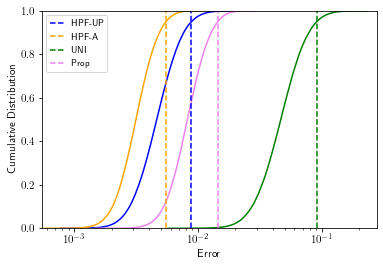

In [37]:
plt.xscale('log')


plt.plot(np.sort(errors_hpfu), np.linspace(0, 1, len(errors_hpfu), endpoint=False), alpha = 1,color='blue')
plt.plot(np.sort(errors_hpfa), np.linspace(0, 1, len(errors_hpfa), endpoint=False), alpha = 1,color='orange')
plt.plot(np.sort(errors_uni), np.linspace(0, 1, len(errors_uni), endpoint=False), alpha = 1,color='green')
plt.plot(np.sort(errors_prop), np.linspace(0, 1, len(errors_prop), endpoint=False), alpha = 1,color='violet')

plt.ylim(0,1)
plt.xlim(min_range, max_range*1.2)

plt.axvline(x = np.quantile(errors_hpfu,0.95), color = 'blue', linestyle = '--', label='HPF-UP',)
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPF-A')
plt.axvline(x = np.quantile(errors_uni,0.95), color = 'green', linestyle = '--', label='UNI')
plt.axvline(x = np.quantile(errors_prop,0.95), color = 'violet', linestyle = '--', label='Prop')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')

plt.legend(loc='upper left')
plt.savefig("Cancer.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [12]:
print(np.quantile(errors_hpfu,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_prop,0.95), np.quantile(errors_uni,0.95), np.quantile(errors_ldp,0.95), np.quantile(est_sm,0.95))
print(np.mean(np.square(errors_hpfue)), np.mean(np.square(errors_hpfa)), np.mean(np.square(errors_uni)), np.mean(np.square(errors_prop)), np.mean(np.square(errors_ldp)), np.mean(np.square(est_sm)))

0.008814626284076438 0.005453460868215771 0.014321706160819798 0.09070982061013007 0.012103899440573976 0.38217738340575635
5.376860322924356e-05 1.2264619185221269e-05 0.0029936070072068646 8.408109562087843e-05 6.987777578349769e-05 0.03559458832286573


In [13]:
### Saving results:
errors_hpfu_cancer = errors_hpfu
errors_hpfa_cancer = errors_hpfa
errors_uni_cancer = errors_uni
errors_prop_cancer = errors_prop
errors_hpfue_cancer = errors_hpfue

### Uncorrelated Synthetic k=5

In [14]:
## Synthetic Dataset
np.random.seed(1)
beta = 0.05
n = 10000
k = 5
trials = int(n*np.log(n)*2)
eps = np.exp(np.random.uniform(-6,6,n))

Dmatrix , counts = gen_dataset(n,k,0.8)
print('Counts is ',counts)
counts = counts/np.sum(counts)

### hpfu ###
begin = time.time()
w_hpfu, result = solve_hetdp_uncor(eps, k, beta, cp.ECOS)
L_hpfu = 2*np.max(w_hpfu/eps)
N_hpfu = np.random.laplace(0,L_hpfu,(k,trials))
end = time.time()
print('Done HPF-U in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = 2*infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,(k,trials))
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### Prop ###
begin = time.time()
w_prop = eps
w_prop = w_prop/np.sum(w_prop)
L_prop = 2*np.max(w_prop/eps)
N_prop = np.random.laplace(0,L_prop,(k,trials))
end = time.time()
print('Done Prop in ',end-begin,' seconds')


### UNI ###
begin = time.time()
eps1 = np.min(eps)
w_uni = np.ones(n)/n
L_uni = 2*np.max(1/eps)/n
N_uni = np.random.laplace(0,L_uni,(k,trials))
end = time.time()
print('Done UNI in ',end-begin,' seconds')


### hpfu ###
begin = time.time()
w_hpfue, result = solve_hetdp_uncor(eps, k, 1, cp.ECOS)
L_hpfue = 2*np.max(w_hpfue/eps)
N_hpfue = np.random.laplace(0,L_hpfue,(k,trials))
end = time.time()
print('Done HPF-UE in ',end-begin,' seconds')


### SM ###
begin = time.time()
t = np.max(eps)
sm_bern_matrix = np.random.binomial(1,(np.exp(eps)-1)/(np.exp(t)-1), (trials,n))
N_sm = np.random.laplace(0,2/(t*np.sum(sm_bern_matrix, axis=1)),size = (k,trials))
end = time.time()
print('Done SM in ',end-begin,' seconds')


### LDP ###
begin = time.time()
w_ldp, result = solve_ldp_uncor(eps, k, beta)
end = time.time()
print('Done LDP in ',end-begin,' seconds')

Counts is  [2907. 2365. 1889. 1625. 1214.]


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done HPF-U in  2.517873764038086  seconds
Done HPF-A in  0.03339219093322754  seconds
Done Prop in  0.03639388084411621  seconds
Done UNI in  0.03203177452087402  seconds
Done HPF-UE in  1.8894128799438477  seconds
Done SM in  61.98192882537842  seconds
Done LDP in  0.0009043216705322266  seconds


In [15]:
errors_hpfu = np.zeros(trials)
errors_hpfa = np.zeros(trials)
errors_prop = np.zeros(trials)
errors_uni = np.zeros(trials)
errors_hpfue = np.zeros(trials)
errors_ldp = np.zeros(trials)
errors_sm = np.zeros(trials)


for _ in tqdm(range(trials)):
	np.random.shuffle(np.transpose(Dmatrix))

	est_hpfu= Dmatrix@w_hpfu + N_hpfu[:,_]
	est_hpfa = Dmatrix@w_hpfa + N_hpfa[:,_]
	est_uni = Dmatrix@w_uni + N_uni[:,_]
	est_prop = Dmatrix@w_prop + N_prop[:,_]
	est_hpfue = Dmatrix@w_hpfue + N_hpfue[:,_]
	est_ldp = kRAPPOR_uncor(eps, Dmatrix, 1)@w_ldp

	w_bern = sm_bern_matrix[_,:]
	w_bern = w_bern/np.sum(w_bern)
	est_sm = Dmatrix@w_bern + N_sm[:,_]

	errors_hpfu[_]= get_error(est_hpfu,counts)
	errors_hpfa[_]= get_error(est_hpfa,counts)
	errors_uni[_]= get_error(est_uni,counts)
	errors_prop[_]= get_error(est_prop,counts)
	errors_hpfue[_]= get_error(est_hpfue,counts)
	errors_ldp[_]= get_error(est_ldp,counts)
	errors_sm[_] = get_error(est_sm,counts)

100%|██████████| 184206/184206 [41:29<00:00, 74.00it/s] 


In [33]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpfu), min(errors_uni) , min(errors_prop))
max_range = max(max(errors_hpfa),max(errors_hpfu), max(errors_uni) , max(errors_prop))

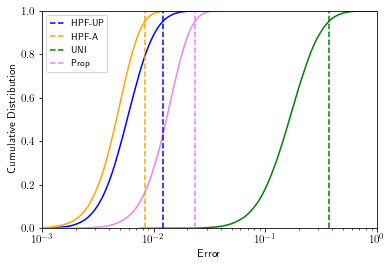

In [49]:
plt.xscale('log')


plt.plot(np.sort(errors_hpfu), np.linspace(0, 1, len(errors_hpfu), endpoint=False), alpha = 1,color='blue')
plt.plot(np.sort(errors_hpfa), np.linspace(0, 1, len(errors_hpfa), endpoint=False), alpha = 1,color='orange')
plt.plot(np.sort(errors_uni), np.linspace(0, 1, len(errors_uni), endpoint=False), alpha = 1,color='green')
plt.plot(np.sort(errors_prop), np.linspace(0, 1, len(errors_prop), endpoint=False), alpha = 1,color='violet')

plt.ylim(0,1)
plt.xlim(0.001, 1)

plt.axvline(x = np.quantile(errors_hpfu,0.95), color = 'blue', linestyle = '--', label='HPF-UP',)
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPF-A')
plt.axvline(x = np.quantile(errors_uni,0.95), color = 'green', linestyle = '--', label='UNI')
plt.axvline(x = np.quantile(errors_prop,0.95), color = 'violet', linestyle = '--', label='Prop')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')

plt.legend(loc='upper left')
plt.savefig("UncorSyn1.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [16]:
print(np.quantile(errors_hpfu,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_prop,0.95), np.quantile(errors_uni,0.95), np.quantile(errors_ldp,0.95), np.quantile(est_sm,0.95), np.quantile(errors_hpfue,0.95))
print(np.mean(np.square(errors_hpfue)), np.mean(np.square(errors_hpfa)), np.mean(np.square(errors_uni)), np.mean(np.square(errors_prop)), np.mean(np.square(errors_ldp)), np.mean(np.square(est_sm)))

0.012066888535923925 0.008326334857397498 0.02340465008524735 0.3701049436632545 0.015223873718396619 0.7979466062052823 0.01813995919408108
0.00010701397233633128 2.7281916997787283e-05 0.043390480101849635 0.00021412680682850836 9.594196908206719e-05 0.19827040210768035


In [17]:
### Saving results:
errors_hpfu_syn1 = errors_hpfu
errors_hpfa_syn1 = errors_hpfa
errors_uni_syn1 = errors_uni
errors_prop_syn1 = errors_prop

### Uncor Syn k=20

In [21]:
## Synthetic Dataset
np.random.seed(1)
beta = 0.05
n = 10000
k = 20
trials = int(n*np.log(n)*2)
eps = np.exp(np.random.uniform(-6,6,n))

Dmatrix , counts = gen_dataset(n,k,0.8)
print('Counts is ',counts)
counts = counts/np.sum(counts)

### hpfu ###
begin = time.time()
w_hpfu, result = solve_hetdp_uncor(eps, k, beta, cp.ECOS)
L_hpfu = 2*np.max(w_hpfu/eps)
N_hpfu = np.random.laplace(0,L_hpfu,(k,trials))
end = time.time()
print('Done HPF-U in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = 2*infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,(k,trials))
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### Prop ###
begin = time.time()
w_prop = eps
w_prop = w_prop/np.sum(w_prop)
L_prop = 2*np.max(w_prop/eps)
N_prop = np.random.laplace(0,L_prop,(k,trials))
end = time.time()
print('Done Prop in ',end-begin,' seconds')


### UNI ###
begin = time.time()
eps1 = np.min(eps)
w_uni = np.ones(n)/n
L_uni = 2*np.max(1/eps)/n
N_uni = np.random.laplace(0,L_uni,(k,trials))
end = time.time()
print('Done UNI in ',end-begin,' seconds')


### hpfue ###
begin = time.time()
w_hpfue, result = solve_hetdp_uncor(eps, k, 1, cp.ECOS)
L_hpfue = 2*np.max(w_hpfue/eps)
N_hpfue = np.random.laplace(0,L_hpfue,(k,trials))
end = time.time()
print('Done HPF-UE in ',end-begin,' seconds')



### SM ###
begin = time.time()
t = np.max(eps)
sm_bern_matrix = np.random.binomial(1,(np.exp(eps)-1)/(np.exp(t)-1), (trials,n))
N_sm = np.random.laplace(0,2/(t*np.sum(sm_bern_matrix, axis=1)),size = (k,trials))
end = time.time()
print('Done SM in ',end-begin,' seconds')


### LDP ###
begin = time.time()
w_ldp, result = solve_ldp_uncor(eps, k, beta)
end = time.time()
print('Done LDP in ',end-begin,' seconds')

Counts is  [2004. 1561. 1265. 1051.  835.  676.  562.  437.  379.  264.  213.  200.
  143.  111.   75.   64.   56.   47.   26.   31.]
Done HPF-U in  2.5599100589752197  seconds
Done HPF-A in  0.10256576538085938  seconds
Done Prop in  0.09769916534423828  seconds
Done UNI in  0.10422420501708984  seconds
Done HPF-UE in  2.071277141571045  seconds
Done SM in  58.447999000549316  seconds
Done LDP in  0.0015077590942382812  seconds


In [22]:
errors_hpfu = np.zeros(trials)
errors_hpfa = np.zeros(trials)
errors_prop = np.zeros(trials)
errors_uni = np.zeros(trials)
errors_hpfue = np.zeros(trials)
errors_ldp = np.zeros(trials)
errors_sm = np.zeros(trials)


for _ in tqdm(range(trials)):
	np.random.shuffle(np.transpose(Dmatrix))
	
	est_hpfu= Dmatrix@w_hpfu + N_hpfu[:,_]
	est_hpfa = Dmatrix@w_hpfa + N_hpfa[:,_]
	est_uni = Dmatrix@w_uni + N_uni[:,_]
	est_prop = Dmatrix@w_prop + N_prop[:,_]
	est_hpfue = Dmatrix@w_hpfue + N_hpfue[:,_]
	est_ldp = kRAPPOR_uncor(eps, Dmatrix, 1)@w_ldp

	w_bern = sm_bern_matrix[_,:]
	w_bern = w_bern/np.sum(w_bern)
	est_sm = Dmatrix@w_bern + N_sm[:,_]


	errors_hpfu[_]= get_error(est_hpfu,counts)
	errors_hpfa[_]= get_error(est_hpfa,counts)
	errors_uni[_]= get_error(est_uni,counts)
	errors_prop[_]= get_error(est_prop,counts)
	errors_hpfue[_]= get_error(est_hpfue,counts)
	errors_ldp[_]= get_error(est_ldp,counts)
	errors_sm[_] = get_error(est_sm,counts)

100%|██████████| 184206/184206 [1:11:24<00:00, 43.00it/s]


In [40]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpfu), min(errors_uni) , min(errors_prop))
max_range = max(max(errors_hpfa),max(errors_hpfu), max(errors_uni) , max(errors_prop))

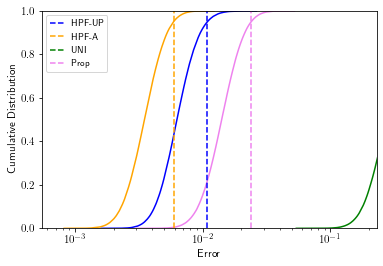

In [53]:
plt.xscale('log')

plt.plot(np.sort(errors_hpfu), np.linspace(0, 1, len(errors_hpfu), endpoint=False), alpha = 1,color='blue')
plt.plot(np.sort(errors_hpfa), np.linspace(0, 1, len(errors_hpfa), endpoint=False), alpha = 1,color='orange')
plt.plot(np.sort(errors_uni), np.linspace(0, 1, len(errors_uni), endpoint=False), alpha = 1,color='green')
plt.plot(np.sort(errors_prop), np.linspace(0, 1, len(errors_prop), endpoint=False), alpha = 1,color='violet')

plt.ylim(0,1)
plt.xlim(min_range, max_range)

plt.axvline(x = np.quantile(errors_hpfu,0.95), color = 'blue', linestyle = '--', label='HPF-UP',)
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPF-A')
plt.axvline(x = np.quantile(errors_uni,0.95), color = 'green', linestyle = '--', label='UNI')
plt.axvline(x = np.quantile(errors_prop,0.95), color = 'violet', linestyle = '--', label='Prop')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')

plt.legend(loc='upper left')
plt.savefig("UncorSyn2.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [23]:
print(np.quantile(errors_hpfu,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_prop,0.95), np.quantile(errors_uni,0.95), np.quantile(errors_ldp,0.95), np.quantile(est_sm,0.95))
print(np.mean(np.square(errors_hpfue)), np.mean(np.square(errors_hpfa)), np.mean(np.square(errors_uni)), np.mean(np.square(errors_prop)), np.mean(np.square(errors_ldp)), np.mean(np.square(est_sm)))

0.01337331847310251 0.007239571717432218 0.02021965332865671 0.4816506596387832 0.014922244237561012 0.34836595243959945
0.0001324226080272763 2.2323098535329862e-05 0.09459984036678623 0.00017276999694489185 0.00011603322153990765 0.02772339966060196


# Mean Estimation

In [24]:
def solve_ldp_cor(eps, k, beta):
	n = len(eps)
	ones = np.ones(n)
	coefs = n+((np.log(k/beta))/np.square(eps))

	w = 1/coefs
	w = w/np.sum(w)
	return w, 1

def solve_ldp_uncor(eps, k, beta):
	n = len(eps)
	ones = np.ones(n)
	coefs = 1+(1/np.square(eps))

	w = 1/coefs
	w = w/np.sum(w)
	return w, 1

## UC Salary, C, P

In [66]:
## Real Dataset
np.random.seed(1)
df =  pd.read_csv('UCData.csv')
x = np.array(df['TotalWages'])
print(np.min(x),np.max(x))
print(len(x))
x = np.random.choice(x,50000,replace=False) #sub-sample dataset

def get_bin(x):
	if x < 1000:
		return 0
	elif x < 5000:
		return 1
	elif x < 15000:
		return 2
	elif x < 30000:
		return 3
	elif x < 60000:
		return 4
	elif x < 120000:
		return 5
	elif x < 240000:
		return 6
	elif x < 480000:
		return 7
	elif x < 960000:
		return 8
	elif x < 2000000:
		return 9
	elif x < 4000000:
		return 10
	else:
		return 11

np.random.seed(1)
eps = np.zeros(len(x))
ct = 0 
for i in range(len(x)):
	eps[i] = np.exp(-abs(get_bin(x[i])-2.5) + np.random.uniform(-3,3))

### Correlated
np.random.seed(1)
beta = 0.05
n = len(x)
k = 1
trials = 5000
scale = 10000000

Data = x
mean = np.sum(Data)/n
print('Mean is ',mean)

### hpfc ###
begin = time.time()
w_hpfc, result = solve_hetdp_cor(eps, k, beta, cp.ECOS)
L_hpfc = np.max(scale*w_hpfc/eps)
N_hpfc = np.random.laplace(0,L_hpfc,trials)
end = time.time()
print('Done HPM-CP in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(scale*w_hpfa/eps)
L_hpfa = infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,trials)
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### Prop ###
begin = time.time()
w_prop = eps
w_prop = w_prop/np.sum(w_prop)
L_prop = scale*np.max(w_prop/eps)
N_prop = np.random.laplace(0,L_prop,trials)
end = time.time()
print('Done Prop in ',end-begin,' seconds')


### UNI ###
begin = time.time()
eps1 = np.min(eps)
w_uni = np.ones(n)/n
L_uni = scale*np.max(1/eps)/n
N_uni = np.random.laplace(0,L_uni,trials)
end = time.time()
print('Done UNI in ',end-begin,' seconds')


### SM ###
begin = time.time()
t = np.max(eps)
sm_bern_matrix = np.random.binomial(1,(np.exp(eps)-1)/(np.exp(t)-1), (trials,n))
N_sm = np.random.laplace(0,scale/(t*np.sum(sm_bern_matrix, axis=1)),size = trials)
end = time.time()
print('Done SM in ',end-begin,' seconds')


### LDP ###
begin = time.time()
w_ldp, result = solve_ldp_cor(eps, k, beta)
ldp_data_matrix = kRAPPOR_cor(eps, Data, trials)
end = time.time()
print('Done LDP in ',end-begin,' seconds')

1 5770000
324043
Mean is  64606.93504


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done HPM-CP in  10.57554006576538  seconds
Done HPF-A in  0.007319927215576172  seconds
Done Prop in  0.003594636917114258  seconds
Done UNI in  0.003741025924682617  seconds
Done SM in  9.865974187850952  seconds


: 

In [65]:
print(eps)

[-0.41578297  1.40403196 -2.39278309 ...  1.81251171 -2.74661975
  2.27919947]
